In [42]:
import pandas as pd

In [43]:
relevant_ads = pd.read_csv("../data/2_interim/relevant_ads.csv")
relevant_transactions = pd.read_csv("../data/2_interim/relevant_transactions.csv")

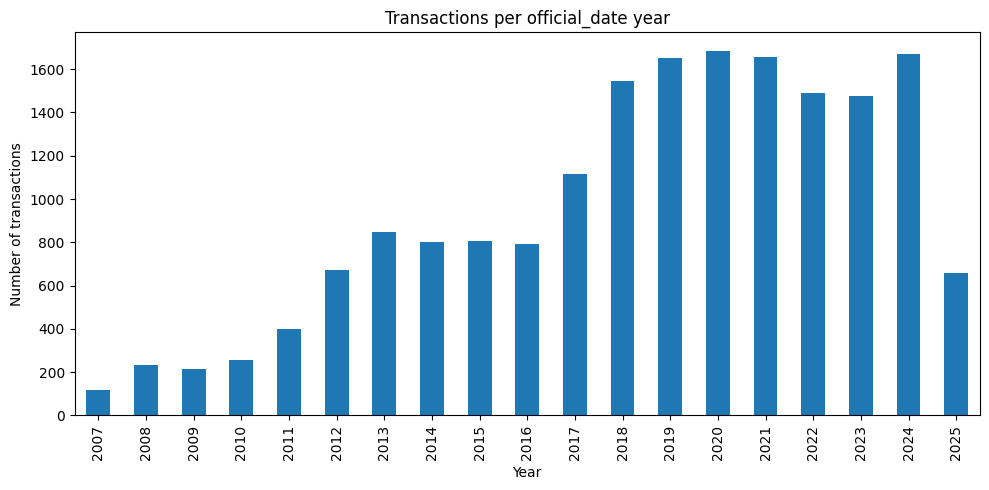

In [44]:
import matplotlib.pyplot as plt

# convert official_date to datetime, extract year and count occurrences
years = pd.to_datetime(relevant_transactions['official_date'], errors='coerce').dt.year
counts = years.dropna().astype(int).value_counts().sort_index()

if counts.empty:
	print("No valid official_date values to plot.")
else:
	plt.figure(figsize=(10, 5))
	counts.plot(kind='bar')
	plt.xlabel('Year')
	plt.ylabel('Number of transactions')
	plt.title('Transactions per official_date year')
	plt.tight_layout()
	plt.show()


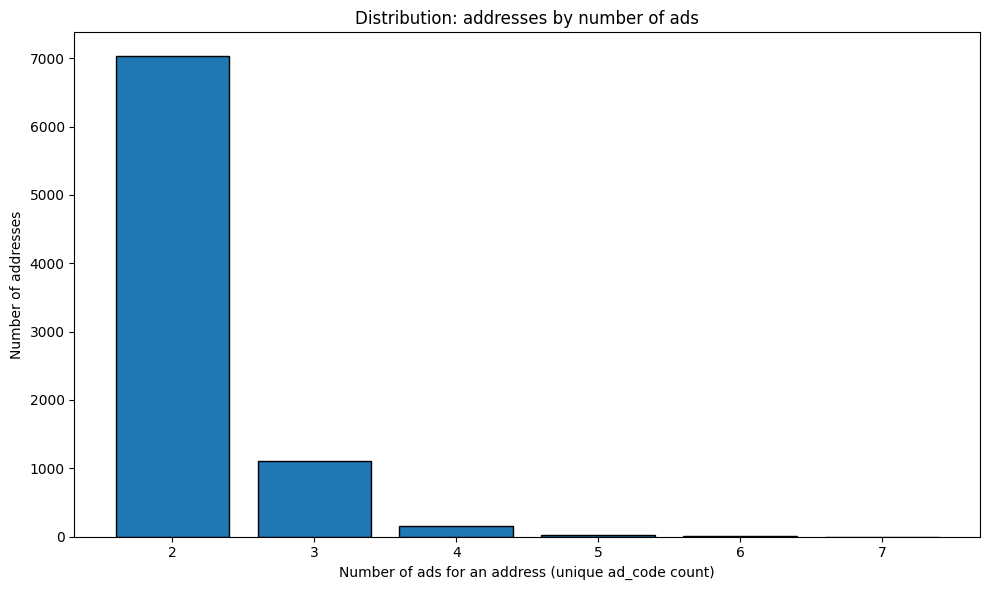

In [45]:
# Count unique ads (ad_code) per address_id and plot distribution:
# x-axis: number of ads for an address (unique ad_code count)
# y-axis: number of addresses that have that many ads

if 'relevant_transactions' not in globals():
	print("relevant_transactions dataframe is not available in the notebook.")
else:
	required_cols = {'address_id', 'ad_code'}
	if not required_cols.issubset(relevant_transactions.columns):
		print(f"Dataframe missing required columns: {required_cols - set(relevant_transactions.columns)}")
	else:
		# number of unique ads per address
		ads_per_address = relevant_transactions.groupby('address_id')['ad_code'].nunique()

		# for each k (number of ads), count how many addresses have exactly k ads
		address_counts = ads_per_address.value_counts().sort_index()

		if address_counts.empty:
			print("No addresses with ads to plot.")
		else:
			plt.figure(figsize=(10, 6))
			x = address_counts.index.astype(int)       # number of ads (1,2,3,...)
			y = address_counts.values                  # number of addresses with that many ads

			# use integer positions to avoid overlapping and ensure clear spacing
			positions = range(len(x))
			plt.bar(positions, y, width=0.8, color='C0', edgecolor='k')

			# label ticks with the actual number of ads
			plt.xticks(positions, x, rotation=0)
			plt.xlabel('Number of ads for an address (unique ad_code count)')
			plt.ylabel('Number of addresses')
			plt.title('Distribution: addresses by number of ads')
			plt.tight_layout()
			plt.show()


In [46]:
# Add 'official_date' to relevant_ads from matching relevant_transactions via ad_code
relevant_ads['official_date'] = (
    relevant_ads['ad_code']
    .map(relevant_transactions.set_index('ad_code')['official_date'])
)

print(
    "Added 'official_date' to relevant_ads. "
    f"Number of ads with a matching transaction date: {relevant_ads['official_date'].notna().sum()}"
)

Added 'official_date' to relevant_ads. Number of ads with a matching transaction date: 18085


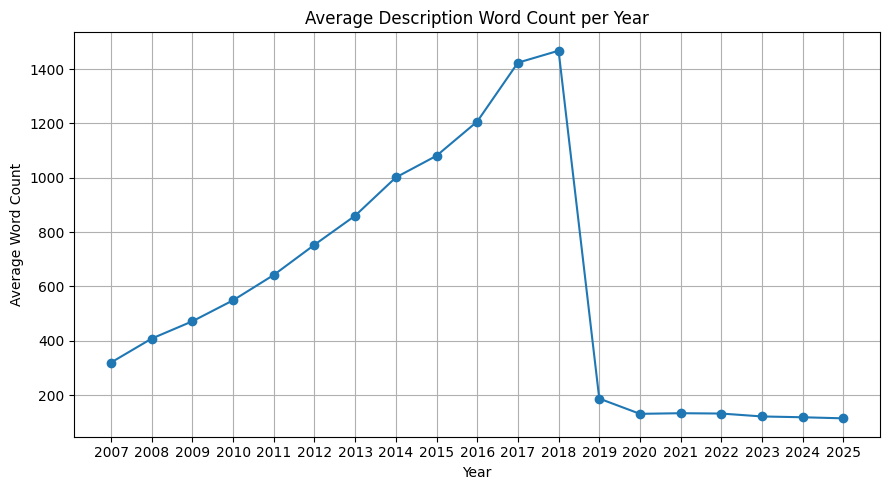

In [47]:
# Ensure official_date is datetime
relevant_ads['official_date'] = pd.to_datetime(relevant_ads['official_date'], errors='coerce')

# Compute word count per ad
relevant_ads['word_count'] = relevant_ads['description'].fillna('').str.split().str.len()

# Extract year
relevant_ads['year'] = relevant_ads['official_date'].dt.year

# Compute average word count per year
avg_wc_per_year = relevant_ads.groupby('year')['word_count'].mean().sort_index()

# Plot with all years on x-axis
plt.figure(figsize=(9, 5))
plt.plot(avg_wc_per_year.index, avg_wc_per_year.values, marker='o')
plt.title('Average Description Word Count per Year')
plt.xlabel('Year')
plt.ylabel('Average Word Count')
plt.xticks(avg_wc_per_year.index)  # Show each year explicitly
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# Add column 'varmepumpe': 1 if 'description' contains 'varmepumpe' (case-insensitive), else 0
relevant_ads['varmepumpe'] = (
    relevant_ads['description'].str.contains('varmepumpe', case=False, na=False).astype(int)
)

print(
    "Added 'varmepumpe' to relevant_ads. "
    f"Count of varmepumpe==1: {relevant_ads['varmepumpe'].sum()}"
)

Added 'varmepumpe' to relevant_ads. Count of varmepumpe==1: 2152


In [49]:
# Add 'varmepumpe' to relevant_transactions based on matching ad_code in relevant_ads
relevant_transactions['varmepumpe'] = (
    relevant_transactions['ad_code']
    .map(relevant_ads.set_index('ad_code')['varmepumpe'])
    .fillna(0)
    .astype(int)
)

print(
    "Added 'varmepumpe' to relevant_transactions. "
    f"Count of varmepumpe==1: {relevant_transactions['varmepumpe'].sum()}"
)

Added 'varmepumpe' to relevant_transactions. Count of varmepumpe==1: 2152


In [50]:
# Ensure proper dtypes
rtx = relevant_transactions.copy()
rtx['official_date'] = pd.to_datetime(rtx['official_date'], format="%Y-%m-%d", errors='coerce')
rtx = rtx.dropna(subset=['official_date'])
rtx['varmepumpe'] = rtx['varmepumpe'].astype(int)

# First date with varmepumpe == 1 per address_id
first_one = (
    rtx.loc[rtx['varmepumpe'] == 1]
    .groupby('address_id')['official_date']
    .min()
    .rename('first_one_date')
)

# Earliest date with varmepumpe == 0 per address_id
first_zero = (
    rtx.loc[rtx['varmepumpe'] == 0]
    .groupby('address_id')['official_date']
    .min()
    .rename('first_zero_date')
)

# Addresses that have a 0 before a later 1
paired = first_one.to_frame().join(first_zero.to_frame(), how='inner')

In [51]:
zero_then_one = paired['first_zero_date'] < paired['first_one_date']

zero_then_one_count_addresses = int(zero_then_one.sum())
print("Number of address_id with a 0-then-later-1:", zero_then_one_count_addresses)

# (Optional) list them:
# addresses_list = paired.index[valid].tolist()

Number of address_id with a 0-then-later-1: 737


In [52]:
one_then_zero = paired['first_one_date'] < paired['first_zero_date']

one_then_zero_count_addresses = int(one_then_zero.sum())
print("Number of address_id with a 1-then-later-0:", one_then_zero_count_addresses)

Number of address_id with a 1-then-later-0: 648


In [53]:
# Ensure varmepumpe is integer (1 or 0)
rtx = relevant_transactions.copy()
rtx['varmepumpe'] = rtx['varmepumpe'].astype(int)

# Group by address_id
grouped = rtx.groupby('address_id')['varmepumpe']

# Addresses where ALL transactions are 1
all_ones = grouped.all()

# Addresses where ALL transactions are 0
all_zeros = ~grouped.any()

# Counts
count_all_ones = int(all_ones.sum())
count_all_zeros = int(all_zeros.sum())

print(f"Number of addresses with ONLY varmepumpe == 1: {count_all_ones}")
print(f"Number of addresses with ONLY varmepumpe == 0: {count_all_zeros}")

Number of addresses with ONLY varmepumpe == 1: 315
Number of addresses with ONLY varmepumpe == 0: 6603


6603+315+648+737=8303=alle addressene